In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.optimize import brentq

Context
* See Nassim Taleb's twitter thread on 19th February about Maximum Ignorance
* Or see Nassim's other posts about the ~"Surgeon's Problem"

Given
* Binomial Distribution
* n_samples
* n_failures (<= n_samples)

Find
* p_event as a function of the observed quantile

In [2]:
# Define parameters
cum_p = 0.5
n_samples = 1057
n_successes = 1

Calculate Cumulative Probability:

In [3]:
bernoulli_p = 1/630  # Value known to give cumulative probability of 0.5 for these parameters

cum_p = binom.cdf(k=n_successes, n=n_samples, p=bernoulli_p)  # args: k, n, p

print("Cumulative Probability:", round(cum_p, 5))

Cumulative Probability: 0.50001


Solve for `bernoulli_p`:

In [4]:
def find_bernoulli_p(target_cum_p, n_successes, n_samples):

    def objective(bernoulli_p, target_cum_p):
        return binom.cdf(n_successes, n_samples, bernoulli_p) - target_cum_p

    # Use brentq to find p in the interval [0, 1]
    bernoulli_p = brentq(objective, 0, 1, args=(target_cum_p,))

    return bernoulli_p

In [5]:
target_cum_p = 0.5

bernoulli_p = find_bernoulli_p(target_cum_p, n_successes, n_samples)
bernoulli_p = round(bernoulli_p, 5)

print("Calculated p:", bernoulli_p)

Calculated p: 0.00159


Plot `bernoulli_p` w.r.t. `cum_p`:

In [6]:
def get_bernoulli_p_by_quantile(n_successes, n_samples):
    """Get bernoulli_p values for each percentile"""

    cum_p_values = np.linspace(0, 1, 1000+1)  # 100+1 gives percentiles

    # Find p_solution for each CDF value
    bernoulli_p_values = [find_bernoulli_p(cum_p, n_successes, n_samples) for cum_p in cum_p_values]
        
    sr = pd.Series(index=cum_p_values, data=bernoulli_p_values)
    sr.index.name = 'cum_p'
    sr.name = 'bernoulli_p'
    
    return sr

In [7]:
median_cum_p = 0.5

median_bernoulli_p = find_bernoulli_p(median_cum_p, n_successes, n_samples)
median_bernoulli_p = round(median_bernoulli_p, 5)
median_bernoulli_p

0.00159

In [8]:
bernoulli_p_sr = get_bernoulli_p_by_quantile(n_successes, n_samples)

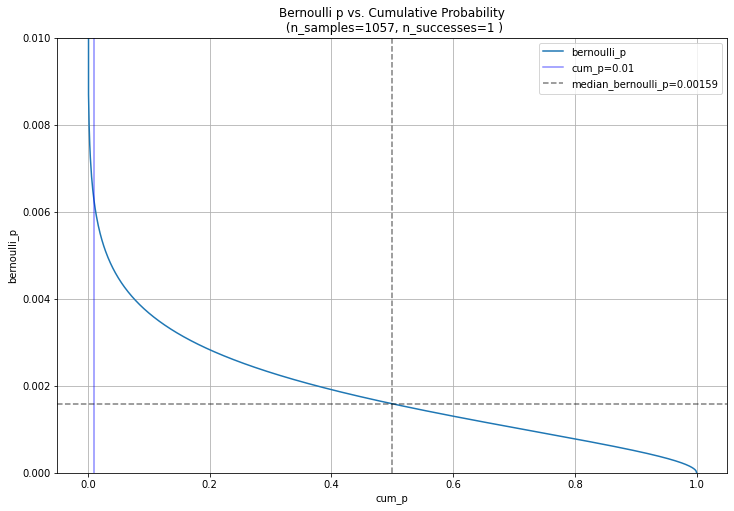

In [45]:
param_values = f'\n ({n_samples=}, {n_successes=} )'
title='Bernoulli p vs. Cumulative Probability' + param_values
ylabel = 'bernoulli_p'
sr = bernoulli_p_sr

ylim=[0, 0.01]

ax = sr.plot(figsize=(12, 8), grid=True, title=title, ylim=ylim, ylabel=ylabel)

context_line_cum_p = 0.01
ax.axvline(context_line_cum_p, color='b', linestyle='-', alpha=0.45, label=f'cum_p={context_line_cum_p}')
ax.axhline(median_bernoulli_p, color='k', linestyle='--', alpha=0.5, label=f'{median_bernoulli_p=}')
ax.axvline(0.5, color='k', linestyle='--', alpha=0.5)
plt.legend(); plt.show()

### Integrate

In [46]:
import numpy as np
from scipy.stats import binom
from scipy.optimize import brentq
from scipy.integrate import quad

def integrate_binomial_p_wrt_bernoulli_cum_p(n_successes, n_samples, x_start=0, x_end=1):
    """Integrate the plot if binomial_p (y) which matches to every binomial cumulative p (x)"""

    def objective(p, cum_p):
        return binom.cdf(n_successes, n_samples, p) - cum_p

    # Define the function to solve for p given a cum_p
    def p_func(cum_p):
        return brentq(objective, 0, 1, args=(cum_p,))

    # Perform numerical integration (integrate p with respect to cum_p from 0 to 1)
    integral_result, error = quad(p_func, x_start, x_end)

    return integral_result, error


In [47]:
quantile_split_point = 0.5

integral_result, error = integrate_binomial_p_wrt_bernoulli_cum_p(n_successes, n_samples)
integral_result = integral_result
error = round(error,5)
print(f'{error=}')

integral_result_lower, error = integrate_binomial_p_wrt_bernoulli_cum_p(n_successes, n_samples, 0, quantile_split_point)
integral_result_lower = round(integral_result_lower, 5)
error = round(error,5)
print(f'{error=}')

integral_result_upper, error = integrate_binomial_p_wrt_bernoulli_cum_p(n_successes, n_samples, quantile_split_point, 1)
integral_result_upper = round(integral_result_upper, 5)
error = round(error,5)
print(f'{error=}')

print('\n')

print(f"Integral of p with respect to CDF value: {round(integral_result, 5)}")
print(f"{integral_result_lower = }")
print(f"{integral_result_upper = }")

error=0.0
error=0.0
error=0.0


Integral of p with respect to CDF value: 0.00189
integral_result_lower = 0.00144
integral_result_upper = 0.00045


Check how the integral breaks down for sections of x-axis:

In [76]:
quantile_split_point = 0.01
sub_integral_value, error = integrate_binomial_p_wrt_bernoulli_cum_p(n_successes, n_samples, 0, quantile_split_point)

print(f"Sub Integral on (0, {quantile_split_point}) = {sub_integral_value:.5f}.")
print(f"Sub Integral on (0, {quantile_split_point}) contributes {100*sub_integral_value/integral_result:.0f}% of the expected value {integral_result:.5f}.")

Sub Integral on (0, 0.01) = 0.00007.
Sub Integral on (0, 0.01) contributes 4% of the expected value 0.00189.


In [75]:
quantile_split_point = 0.1
sub_integral_value, error = integrate_binomial_p_wrt_bernoulli_cum_p(n_successes, n_samples, 0, quantile_split_point)

print(f"Sub Integral on (0, {quantile_split_point}) = {sub_integral_value:.5f}.")
print(f"Sub Integral on (0, {quantile_split_point}) contributes {100*sub_integral_value/integral_result:.0f}% of the expected value {integral_result:.5f}.")

Sub Integral on (0, 0.1) = 0.00048.
Sub Integral on (0, 0.1) contributes 25% of the expected value 0.00189.


In [80]:
quantile_split_point = 0.05
sub_integral_value, error = integrate_binomial_p_wrt_bernoulli_cum_p(n_successes, n_samples, quantile_split_point, 1)

print(f"Sub Integral on ({quantile_split_point}, 1) = {sub_integral_value:.5f}.")
print(f"Sub Integral on ({quantile_split_point}, 1) contributes {100*sub_integral_value/integral_result:.0f}% of the expected value {integral_result:.5f}.")

Sub Integral on (0.05, 1) = 0.00161.
Sub Integral on (0.05, 1) contributes 85% of the expected value 0.00189.


In [86]:
# ROUGHWORK Note
# * Show right to left cumulative average evolves as you approach the large values on the left
# bernoulli_p_sr.loc[::-1].cum_mean()

### Plot again with Expected Value

In [77]:
mean_bernoulli_p = integral_result
mean_bernoulli_p = round(mean_bernoulli_p, 5)

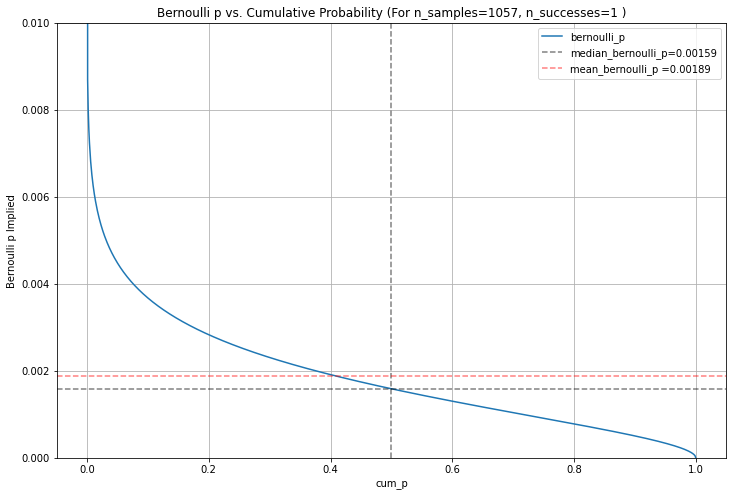

In [78]:
param_values = f' (For {n_samples=}, {n_successes=} )'
title='Bernoulli p vs. Cumulative Probability' + param_values
ylabel = 'Bernoulli p Implied'
sr = bernoulli_p_sr

ylim=[0, 0.01]

ax = sr.plot(figsize=(12, 8), grid=True, title=title, ylim=ylim, ylabel=ylabel)

# --------------------------------------------------------------------------------------------------------------
# Context Lines

ax.axhline(median_bernoulli_p, color='k', linestyle='--', alpha=0.5, label=f'{median_bernoulli_p=}')
ax.axvline(median_cum_p, color='k', linestyle='--', alpha=0.5)

ax.axhline(mean_bernoulli_p, color='r', linestyle='--', alpha=0.5, label=f'{mean_bernoulli_p =}')
#ax.axhline(mean_cum_p,    color='r', linestyle='--', alpha=0.5)

plt.legend(); plt.show()

In [89]:
print(f'Max Ignorance Median Implies One in {round(1/median_bernoulli_p)}')
print(f'Max Ignorance Mean Implies One in {round(1/mean_bernoulli_p)}')

Max Ignorance Median Implies One in 629
Max Ignorance Mean Implies One in 529


# Extensions
* Suppose you find out that p > x (p has a lower bound)
* Compare my estimated mean_bernoulli_p against bernoulli_p which maximises entropy of binomial distribution(n_samples, n_successes)